# NLP-LAB Exercise 02 by Jonas Weinz (2571421)
## links:

* Article: https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/
    * corresponding code: https://github.com/kjam/random_hackery/blob/master/Attempting%20to%20detect%20fake%20news.ipynb

* Tutorial on Datacamp: https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

* liar dataset paper: https://www.cs.ucsb.edu/~william/papers/acl2017.pdf
    * dataset: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

* Mex Vocabulary: http://jens-lehmann.org/files/2015/semantics_mex.pdf

## Dependencies for this Notebook:
* library [rdflib](https://github.com/RDFLib/rdflib)
    * install: `pip3 install rdflib`


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import itertools
import sklearn.utils as sku
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from pprint import pprint as pp
from IPython.display import display, Markdown, Latex
import collections
import traceback
import os


## Tools used later

In [3]:
def plot_confusion_matrix(cm, classes,
                          title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    fig_1, ax_1 = plt.subplots()
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix for:\n' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    
    pp(cm)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def test_classifier(labels, title, Xt, yt, clf):
    pred = clf.predict(Xt)
    score = metrics.accuracy_score(yt, pred)
    pp("score: " + str(score))
    cm = metrics.confusion_matrix(yt, pred, labels=labels)
    plot_confusion_matrix(cm, classes=labels, title=title)
    return cm

In [5]:
'''
from rdflib import Graph, Literal, BNode, RDF, Namespace
from rdflib.namespace import FOAF, DC, XSD

mexcore = Namespace('http://mex.aksw.org/mex-core#')
mexperf = Namespace('http://mex.aksw.org/mex-perf#')
mexalgo = Namespace('http://mex.aksw.org/mex-algo#')
prov = Namespace('http://www.w3.org/ns/prov#')

def create_mex_graph():
    graph = Graph()
    graph.bind(mexcore)
    graph.bind(mexperf)
    graph.bind(mexalgo)
    graph.bind(prov)
    graph.bind(FOAF)
    graph.bind(DC)
    graph.bind(XSD)
    
    return graph

def mex_performance(experiment, model, dataset, performance, phase='Train', graph=create_mex_graph()):
    
    p = BNode()
    
'''

"\nfrom rdflib import Graph, Literal, BNode, RDF, Namespace\nfrom rdflib.namespace import FOAF, DC, XSD\n\nmexcore = Namespace('http://mex.aksw.org/mex-core#')\nmexperf = Namespace('http://mex.aksw.org/mex-perf#')\nmexalgo = Namespace('http://mex.aksw.org/mex-algo#')\nprov = Namespace('http://www.w3.org/ns/prov#')\n\ndef create_mex_graph():\n    graph = Graph()\n    graph.bind(mexcore)\n    graph.bind(mexperf)\n    graph.bind(mexalgo)\n    graph.bind(prov)\n    graph.bind(FOAF)\n    graph.bind(DC)\n    graph.bind(XSD)\n    \n    return graph\n\ndef mex_performance(experiment, model, dataset, performance, phase='Train', graph=create_mex_graph()):\n    \n    p = BNode()\n    \n"

## Generate/Download Datasets we are working on

* running bash script to download all needed data and store it into the `data` subfolder

In [6]:
%%bash
./Task_2_gen_data.sh

checking whether unzip is installed
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Latest sources and executables are at ftp://ftp.info-zip.org/pub/infozip/ ;
see ftp://ftp.info-zip.org/pub/infozip/UnZip.html for other sites.

Compiled with gcc 6.3.0 20170415 for Unix (Linux ELF).

UnZip special compilation options:
        ACORN_FTYPE_NFS
        COPYRIGHT_CLEAN (PKZIP 0.9x unreducing method not supported)
        SET_DIR_ATTRIB
        SYMLINKS (symbolic links supported, if RTL and file system permit)
        TIMESTAMP
        UNIXBACKUP
        USE_EF_UT_TIME
        USE_UNSHRINK (PKZIP/Zip 1.x unshrinking method supported)
        USE_DEFLATE64 (PKZIP 4.x Deflate64(tm) supported)
        UNICODE_SUPPORT [wide-chars, char coding: UTF-8] (handle UTF-8 paths)
        LARGE_FILE_SUPPORT (large files over 2 GiB supported)
        ZIP64_SUPPORT (archives using Zip64 for large files supported)
        USE_BZIP2 (PKZIP 4.6+, using bzip2 lib version 1.0.6, 6-Sept-2010)
     

----
## configuration 1

In [7]:
df_1 = pd.read_csv('data/fake_or_real_news.csv').set_index('Unnamed: 0')

* display first 10 entries

In [8]:
display(df_1.shape)
display(df_1[:10])

(6335, 3)

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL


* create test dataset

In [9]:
X1, Xt1, y1, yt1 = train_test_split(df_1.drop('label', axis=1)['text'], df_1.label, test_size=0.25, random_state=4222)

In [10]:
vectorizer_1 = TfidfVectorizer(stop_words='english', max_df=0.7)
vec_train_1 = vectorizer_1.fit_transform(X1)
vec_test_1 = vectorizer_1.transform(Xt1)

* trying a Random Forest classifier 

'score: 0.9960008419280152'
Confusion matrix, without normalization
array([[2342,    3],
       [  16, 2390]])
'score: 0.8478535353535354'
Confusion matrix, without normalization
array([[737,  82],
       [159, 606]])


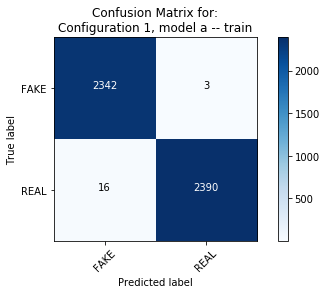

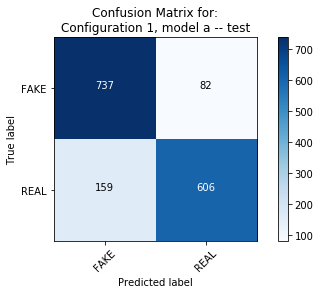

In [11]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf_a = RFC(criterion='entropy', random_state=4222)
max_size=10000
clf_a.fit(vec_train_1[:max_size], y1[:max_size])
test_classifier(labels=["FAKE","REAL"], title="Configuration 1, model a -- train", Xt=vec_train_1,yt=y1, clf=clf_a)
cm_1 = test_classifier(labels=["FAKE","REAL"], title="Configuration 1, model a -- test", Xt=vec_test_1,yt=yt1, clf=clf_a)

----
## configuration 2

* read data

In [12]:
names = [
    "id",
    "label",
    "statement",
    "subjects",
    "speaker",
    "job",
    "state",
    "party",
    "#barely_true",
    "#false",
    "#half_true",
    "#mostly_true",
    "#pants_on_fire",
    "context"
]

df_2_train = pd.read_csv("data/train.tsv", delimiter='\t', names=names)
df_2_test = pd.read_csv("data/test.tsv", delimiter='\t', names=names)
df_2_valid= pd.read_csv("data/valid.tsv", delimiter='\t', names=names)

# use only 'False' and 'True' statements
df_2_train = df_2_train[df_2_train['label'].isin(["false","true"])]
df_2_test = df_2_test[df_2_test['label'].isin(["false","true"])]
df_2_valid = df_2_valid[df_2_valid['label'].isin(["false","true"])]

display(Markdown("----\n#### Train Data:"))
display(df_2_train.head())
display(Markdown("----\n#### Test Data:"))
display(df_2_test.head())
display(Markdown("----\n#### Valid Data:"))
display(df_2_valid.head())

----
#### Train Data:

,id,label,statement,subjects,speaker,job,state,party,#barely_true,#false,#half_true,#mostly_true,#pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
12,5947.json,false,When Mitt Romney was governor of Massachusetts...,"history,state-budget",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,an interview with CBN News
16,620.json,true,McCain opposed a requirement that the governme...,federal-budget,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a radio ad


----
#### Test Data:

,id,label,statement,subjects,speaker,job,state,party,#barely_true,#false,#half_true,#mostly_true,#pants_on_fire,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
5,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website
6,7070.json,true,Says that Tennessee law requires that schools ...,"county-budget,county-government,education,taxes",stand-children-tennessee,Child and education advocacy organization.,Tennessee,none,0,0,0,0,0,in a post on Facebook.


----
#### Valid Data:

,id,label,statement,subjects,speaker,job,state,party,#barely_true,#false,#half_true,#mostly_true,#pants_on_fire,context
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
5,9416.json,false,Says when armed civilians stop mass shootings ...,guns,jim-rubens,Small business owner,New Hampshire,republican,1,1,0,1,0,"in an interview at gun shop in Hudson, N.H."
6,6861.json,true,Says Tennessee is providing millions of dollar...,"education,state-budget",andy-berke,Lawyer and state senator,Tennessee,democrat,0,0,0,0,0,a letter to state Senate education committee c...
7,1122.json,false,The health care reform plan would set limits s...,health-care,club-growth,NaN,NaN,none,4,5,4,2,0,a TV ad
8,13138.json,true,Says Donald Trump started his career back in 1...,"candidates-biography,diversity,housing",hillary-clinton,Presidential candidate,New York,democrat,40,29,69,76,7,the first presidential debate


#### tdidf vectorizer on new dataset


In [13]:
X2 = df_2_train['statement']
y2 = df_2_train['label']
Xt2 = df_2_test['statement']
yt2 = df_2_test['label']
Xv2 = df_2_valid['statement']
yv2 = df_2_valid['label']


In [14]:
vectorizer_2 = TfidfVectorizer(stop_words='english', max_df=0.7)
vec_train_2 = vectorizer_2.fit_transform(X2)
vec_test_2 = vectorizer_2.transform(Xt2)

In [15]:
?MLPClassifier

Object `MLPClassifier` not found.


* trying a MLP as classifier 

In [16]:
from sklearn.neural_network import MLPClassifier
clf_b = MLPClassifier(hidden_layer_sizes=(100,), random_state=4222)
clf_b.fit(vec_train_2, y2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=4222,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

'score: 0.9997275946608554'
Confusion matrix, without normalization
array([[1675,    1],
       [   0, 1995]])
'score: 0.5776805251641138'
Confusion matrix, without normalization
array([[109,  99],
       [ 94, 155]])
'score: 0.6041666666666666'
Confusion matrix, without normalization
array([[ 92,  77],
       [ 94, 169]])


array([[ 92,  77],
       [ 94, 169]])

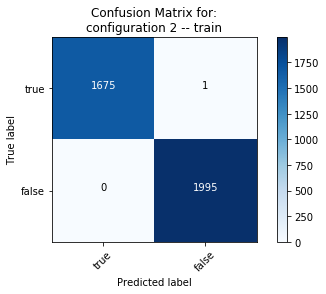

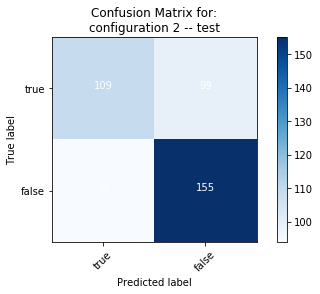

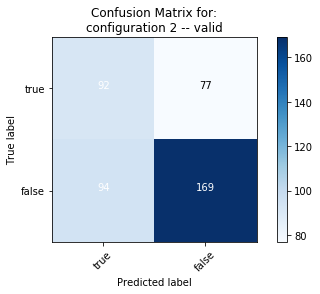

In [17]:
test_classifier(labels=["true", "false"], title="configuration 2 -- train", Xt=vec_train_2, yt=y2, clf=clf_b)
cm_2 = test_classifier(labels=["true", "false"], title="configuration 2 -- test", Xt=vec_test_2, yt=yt2, clf=clf_b)
test_classifier(labels=["true", "false"], title="configuration 2 -- valid", Xt=vectorizer_2.transform(Xv2), yt=yv2, clf=clf_b)

----
## configuration 3

'score: 0.5142231947483589'
Confusion matrix, without normalization
array([[  7, 201],
       [ 21, 228]])


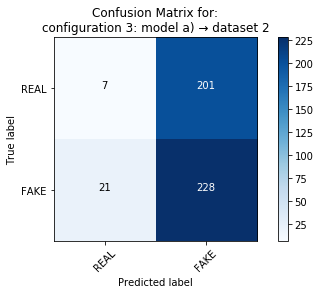

In [18]:
yt2_c3 = yt2.copy()
yt2_c3[yt2_c3 == "true"] = "REAL"
yt2_c3[yt2_c3 == "false"] = "FAKE"

cm_3b=test_classifier(labels=["REAL", "FAKE"], 
                title="configuration 3: model a) → dataset 2",
                Xt=vectorizer_1.transform(Xt2),
                yt=yt2_c3, clf=clf_a)

'score: 0.5391414141414141'
Confusion matrix, without normalization
array([[274, 491],
       [239, 580]])


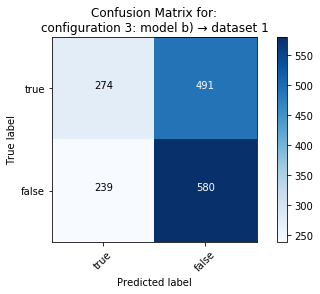

In [19]:
yt1_c3 = yt1.copy()
yt1_c3[yt1_c3 == "REAL"] = "true"
yt1_c3[yt1_c3 == "FAKE"] = "false"

cm_3a=test_classifier(labels=["true", "false"], 
                title="configuration 3: model b) → dataset 1",
                Xt=vectorizer_2.transform(Xt1),
                yt=yt1_c3, clf=clf_b)

----
## configuration 4)

In [20]:
def get_dataset3_split(dataset1_in, dataset2_in):
    try:
        print('processing datasets')
        print('ds1=', dataset1_in)
        print('ds2=', dataset2_in)

        print('-- fake news')
        df1 = pd.read_csv(dataset1_in, sep=',', usecols=['title','text','label'])
        df1['claim'] = df1[['title', 'text']].apply(lambda x: '. '.join(x), axis=1)
        del df1['title']
        del df1['text']
        df1.rename(index=str, columns={'label': 'y'}, inplace=True)
        print(df1.keys())
        print(len(df1[df1['y']=='REAL']))
        print(len(df1[df1['y']=='FAKE']))
        df1['y'] = np.where(df1['y'] == 'FAKE', 'false', 'true')
        print(len(df1))

        print('-- liar liar')
        df2 = pd.read_csv(dataset2_in, sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
        print(df2.keys())
        print(set(df2.y), len(df2))
        print(len(df2[df2['y'] == 'true']))
        print(len(df2[df2['y'] == 'false']))
        df2=df2[(df2['y'] == 'true') | (df2['y'] == 'false')]
        print(set(df2.y), len(df2))

        df3=pd.concat([df1, df2], ignore_index=True)

        print(df3['y'].value_counts())
        print('done')
        return train_test_split(df3['claim'], df3['y'], test_size=0.3, random_state=4222)
    except Exception as e:
        print(e)

In [21]:
X3, Xt3, y3, yt3 = get_dataset3_split('data/fake_or_real_news.csv', 'data/train.tsv')

processing datasets
ds1= data/fake_or_real_news.csv
ds2= data/train.tsv
-- fake news
Index(['y', 'claim'], dtype='object')
3171
3164
6335
-- liar liar
Index(['y', 'claim'], dtype='object')
{'half-true', 'false', 'pants-fire', 'mostly-true', 'true', 'barely-true'} 10240
1676
1995
{'false', 'true'} 3671
false    5159
true     4847
Name: y, dtype: int64
done


In [22]:
vectorizer_3 = TfidfVectorizer(stop_words='english', max_df=0.7)
vec_train_3 = vectorizer_3.fit_transform(X3)
vec_test_3 = vectorizer_3.transform(Xt3)

* using MLP again

In [23]:
clf_3 = MLPClassifier(hidden_layer_sizes=(16,16), random_state=4222)
clf_3.fit(vec_train_3, y3)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 16), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=4222,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

'score: 0.9997144488863506'
Confusion matrix, without normalization
array([[3367,    1],
       [   1, 3635]])
'score: 0.7714856762158561'
Confusion matrix, without normalization
array([[1136,  343],
       [ 343, 1180]])


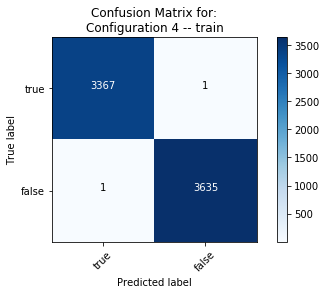

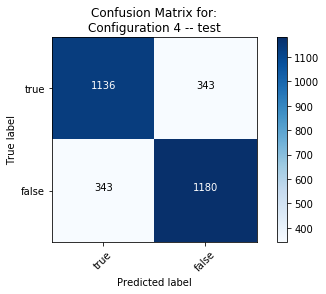

In [24]:
test_classifier(labels=["true","false"], title="Configuration 4 -- train", Xt=vec_train_3, yt=y3, clf=clf_3)
cm_4=test_classifier(labels=["true","false"], title="Configuration 4 -- test", Xt=vec_test_3, yt=yt3, clf=clf_3)

### exporting

In [25]:
def recall(cm):
    return cm[0,0] / (cm[0,0] + cm[0,1])
def precision(cm):
    return cm[0,0] / (cm[0,0] + cm[1,0])

def accuracy(cm):
    return (cm[0,0] + cm[1,1]) / np.sum(cm)

In [26]:
from rdflib import Namespace, Graph, Literal
from rdflib.namespace import DCTERMS, RDF

In [27]:
nsp = {
    "this": Namespace("http://mex.aksw.org/examples/"),
    "xsd": Namespace("http://www.w3.org/2001/XMLSchema#"),
    "rdfs": Namespace("http://www.w3.org/2000/01/rdf-schema#"),
    "mexcore": Namespace("http://mex.aksw.org/mex-core#"),
    "mexperf": Namespace("http://mex.aksw.org/mex-perf#"),
    "mexalgo": Namespace("http://mex.aksw.org/mex-algo#"),
    "prov": Namespace("http://www.w3.org/ns/prov#"),
    "dct": DCTERMS,
    "rdf": RDF
}
g = Graph()

for i in nsp.items():
    g.bind(i[0],i[1])

g.add((nsp["this"].jonas_weinz_task_2, nsp["rdf"].type, nsp["mexcore"].Experiment))

g.add((nsp["this"].ds1, nsp["rdf"].type, nsp["mexcore"].dataset))
g.add((nsp["this"].ds1, nsp["rdfs"].label, Literal("Dataset01")))

g.add((nsp["this"].ds2, nsp["rdf"].type, nsp["mexcore"].dataset))
g.add((nsp["this"].ds2, nsp["rdfs"].label, Literal("Dataset02")))

g.add((nsp["this"].ds3, nsp["rdf"].type, nsp["mexcore"].dataset))
g.add((nsp["this"].ds3, nsp["rdfs"].label, Literal("Dataset03")))

g.add((nsp["this"].modela,nsp["rdf"].type,nsp["mexalgo"].Algorithm))
g.add((nsp["this"].modela,nsp["rdfs"].label,Literal('model a')))
g.add((nsp["this"].modela,nsp["dct"].identifier,Literal('RandomForestClassifier')))

g.add((nsp["this"].modelb,nsp["rdf"].type,nsp["mexalgo"].Algorithm))
g.add((nsp["this"].modelb,nsp["rdfs"].label,Literal('model b')))
g.add((nsp["this"].modelb,nsp["dct"].identifier,Literal('MLPClassifier')))

g.add((nsp["this"].modelc,nsp["rdf"].type,nsp["mexalgo"].Algorithm))
g.add((nsp["this"].modelc,nsp["rdfs"].label,Literal('model c')))
g.add((nsp["this"].modelc,nsp["dct"].identifier,Literal('MLPClassifier')))

g.add((nsp["this"].conf1,nsp["rdf"].type,nsp["mexcore"].ExperimentConfiguration))
g.add((nsp["this"].conf1,nsp["rdfs"].label,Literal('configuration 1')))
g.add((nsp["this"].conf1,nsp["prov"].used, nsp["this"].modela))
g.add((nsp["this"].conf1,nsp["prov"].used, nsp["this"].ds1))
g.add((nsp["this"].conf1,nsp["prov"].wasStartedBy, nsp["this"].jonas_weinz_task_2))

g.add((nsp["this"].conf2,nsp["rdf"].type,nsp["mexcore"].ExperimentConfiguration))
g.add((nsp["this"].conf2,nsp["rdfs"].label,Literal('configuration 2')))
g.add((nsp["this"].conf2,nsp["prov"].used, nsp["this"].modelb))
g.add((nsp["this"].conf2,nsp["prov"].used, nsp["this"].ds2))
g.add((nsp["this"].conf2,nsp["prov"].wasStartedBy, nsp["this"].jonas_weinz_task_2))

g.add((nsp["this"].conf3a,nsp["rdf"].type,nsp["mexcore"].ExperimentConfiguration))
g.add((nsp["this"].conf3a,nsp["rdfs"].label,Literal('configuration 3a')))
g.add((nsp["this"].conf3a,nsp["prov"].used, nsp["this"].modelb))
g.add((nsp["this"].conf3a,nsp["prov"].used, nsp["this"].ds1))
g.add((nsp["this"].conf3a,nsp["prov"].wasStartedBy, nsp["this"].jonas_weinz_task_2))

g.add((nsp["this"].conf3b,nsp["rdf"].type,nsp["mexcore"].ExperimentConfiguration))
g.add((nsp["this"].conf3b,nsp["rdfs"].label,Literal('configuration 3b')))
g.add((nsp["this"].conf3b,nsp["prov"].used, nsp["this"].modela))
g.add((nsp["this"].conf3b,nsp["prov"].used, nsp["this"].ds2))
g.add((nsp["this"].conf3b,nsp["prov"].wasStartedBy, nsp["this"].jonas_weinz_task_2))
      
g.add((nsp["this"].conf4,nsp["rdf"].type,nsp["mexcore"].ExperimentConfiguration))
g.add((nsp["this"].conf4,nsp["rdfs"].label,Literal('configuration 4')))
g.add((nsp["this"].conf4,nsp["prov"].used, nsp["this"].modelc))
g.add((nsp["this"].conf4,nsp["prov"].used, nsp["this"].ds3))
g.add((nsp["this"].conf4,nsp["prov"].wasStartedBy, nsp["this"].jonas_weinz_task_2))

g.add((nsp["this"].measure1,nsp["rdf"].type,nsp["mexcore"].PerformanceMeasure))
g.add((nsp["this"].measure1,nsp["mexperf"].precision,Literal(str(precision(cm_1)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure1,nsp["mexperf"].recall,Literal(str(recall(cm_1)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure1,nsp["mexperf"].accuracy,Literal(str(accuracy(cm_1)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure1,nsp["prov"].wasGeneratedBy,nsp["this"].conf1))

g.add((nsp["this"].measure2,nsp["rdf"].type,nsp["mexcore"].PerformanceMeasure))
g.add((nsp["this"].measure2,nsp["mexperf"].precision,Literal(str(precision(cm_2)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure2,nsp["mexperf"].recall,Literal(str(recall(cm_2)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure2,nsp["mexperf"].accuracy,Literal(str(accuracy(cm_2)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure2,nsp["prov"].wasGeneratedBy,nsp["this"].conf2))

g.add((nsp["this"].measure3a,nsp["rdf"].type,nsp["mexcore"].PerformanceMeasure))
g.add((nsp["this"].measure3a,nsp["mexperf"].precision,Literal(str(precision(cm_3a)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3a,nsp["mexperf"].recall,Literal(str(recall(cm_3a)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3a,nsp["mexperf"].accuracy,Literal(str(accuracy(cm_3a)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3a,nsp["prov"].wasGeneratedBy,nsp["this"].conf3a))

g.add((nsp["this"].measure3b,nsp["rdf"].type,nsp["mexcore"].PerformanceMeasure))
g.add((nsp["this"].measure3b,nsp["mexperf"].precision,Literal(str(precision(cm_3b)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3b,nsp["mexperf"].recall,Literal(str(recall(cm_3b)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3b,nsp["mexperf"].accuracy,Literal(str(accuracy(cm_3b)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure3b,nsp["prov"].wasGeneratedBy,nsp["this"].conf3b))

g.add((nsp["this"].measure4,nsp["rdf"].type,nsp["mexcore"].PerformanceMeasure))
g.add((nsp["this"].measure4,nsp["mexperf"].precision,Literal(str(precision(cm_4)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure4,nsp["mexperf"].recall,Literal(str(recall(cm_4)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure4,nsp["mexperf"].accuracy,Literal(str(accuracy(cm_4)),datatype=nsp["xsd"].float)))
g.add((nsp["this"].measure4,nsp["prov"].wasGeneratedBy,nsp["this"].conf4))


In [28]:
g.serialize(destination='output.ttl', format='turtle')